In [1]:
import tensorflow as tf


In [2]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt


In [3]:
#import tensorflow dependancies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


In [4]:
#avoid out of memory erros by setting gpu memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [38]:
#setup paths
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','neagtive')
ANC_PATH = os.path.join('data','anchor')

In [39]:
#make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)


FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [ ]:
#uncompress the tar gz dataset
!tar -xf lfw.tgz

In [ ]:
#move the images to the negative directory insided data from all the lfw directories
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

In [41]:
import uuid

In [42]:
#establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to grab frame")
        break
    #cut down frame to 250*250 px
    frame = frame[140:140+250,120:120+250,:]
    
    #collecting anchors:
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #ccreate the unique file path
        imgname = os.path.join(ANC_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    
    
    #collecting postitives:
    
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #ccreate the unique file path
        imgname = os.path.join(POS_PATH,'{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname,frame)
    
    
    #show image back to screen
    cv2.imshow('Image Collection', frame)
    
    #breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
    
#release the webcam
cap.release()
#close the image show frame
cv2.destroyAllWindows()
    

In [43]:
frame[140:140+250,120:120+250,:].shape

(110, 130, 3)

In [44]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*jpg').take(300)


In [45]:
def preprocess(file_path):
    # read in image from the file path
    byte_image = tf.io.read_file(file_path)
    
    #load in the image
    img = tf.io.decode_jpeg(byte_image)
    
    # preprocessing steps - resizing the image to be 100*100*3
    img = tf.image.resize(img,(100,100))
    #scale image to be in between 0 and 1 
    img = img/255.0
    return img

create labelled dataset



In [46]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [47]:
data

<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [48]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [49]:
samples = data.as_numpy_iterator()

In [50]:
examples = samples.next()

In [51]:
examples

(b'data\\anchor\\2968bae5-2a31-11ef-935f-9fc61156632e.jpg',
 b'data\\positive\\7087f3e7-2a31-11ef-8248-9fc61156632e.jpg',
 1.0)

In [52]:
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img), preprocess(validation_img), label)

In [53]:
res = preprocess_twin(*examples)

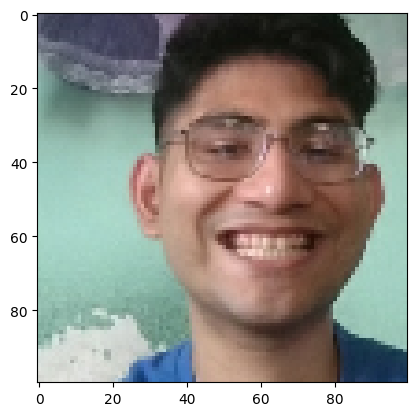

In [54]:
plt.imshow(res[1])

In [55]:
res[2]

1.0

In [56]:
#buidl dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [57]:
data

<ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [58]:
samples  = data.as_numpy_iterator()

In [59]:
len(samples.next())

3

In [60]:
sam = samples.next()

In [61]:
sam[2]

0.0

In [62]:
#training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [63]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [64]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [65]:
inp = Input(shape=(105,105,3),name='input_image')

In [66]:
inp

<KerasTensor: shape=(None, 105, 105, 3) dtype=float32 (created by layer 'input_image')>

In [67]:
c1 = Conv2D(64,(10,10), activation='relu')(inp)

In [68]:
c1

<KerasTensor: shape=(None, 96, 96, 64) dtype=float32 (created by layer 'conv2d')>

In [69]:
m1 = MaxPooling2D(64,(2,2),padding='same')(c1)

In [70]:
m1

<KerasTensor: shape=(None, 48, 48, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [71]:
c2 = Conv2D(128,(7,7),activation="relu")(m1)
m2 = MaxPooling2D(64,(2,2),padding='same')(c2)

In [72]:
c2

<KerasTensor: shape=(None, 42, 42, 128) dtype=float32 (created by layer 'conv2d_1')>

In [73]:
m2

<KerasTensor: shape=(None, 21, 21, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [74]:
c3 = Conv2D(128,(4,4),activation="relu")(m2)
m3 = MaxPooling2D(64,(2,2),padding='same')(c3)

In [75]:
c3

<KerasTensor: shape=(None, 18, 18, 128) dtype=float32 (created by layer 'conv2d_2')>

In [76]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [77]:
#final embedding block
c4 = Conv2D(256,(4,4),activation="relu")(m3)
f1 = Flatten()(c4)
d1 = Dense(4096,activation='sigmoid')(f1)

In [78]:
mod = Model(inputs=[inp],outputs=[d1],name="embedding")

In [79]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [80]:
def make_embedding():
    inp = Input(shape=(100,100,3),name='input_image')
    c1 = Conv2D(64,(10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64,(2,2),padding='same')(c1)
    
    c2 = Conv2D(128,(7,7),activation="relu")(m1)
    m2 = MaxPooling2D(64,(2,2),padding='same')(c2)
    
    c3 = Conv2D(128,(4,4),activation="relu")(m2)
    m3 = MaxPooling2D(64,(2,2),padding='same')(c3)
    
    #final embedding block
    c4 = Conv2D(256,(4,4),activation="relu")(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096,activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp],outputs=[d1],name="embedding")

In [81]:
embedding = make_embedding()

In [82]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

In [83]:
class L1Dist(Layer):
    def __init__(self,**kwargs):
        super().__init__()
        
    def call(self,input_embedding,validation_embeddding):
        return tf.math.abs(input_embedding-validation_embeddding)

In [84]:
l1 = L1Dist()

In [85]:
input_image = Input(name='input_img',shape=(100,100,3))
validation_image = Input(name="validation_img",shape=(100,100,3))
    


In [86]:
inp_embedding=embedding(input_image)
val_embedding = embedding(validation_image)

In [87]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [88]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [89]:
siamese_layer = L1Dist()

In [90]:
distances=siamese_layer(inp_embedding,val_embedding)

In [91]:
classifier = Dense(1,activation='sigmoid')(distances)

In [92]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [93]:
siamese_network =Model(inputs=[input_image,validation_image],outputs= classifier,name = 'SiameseNetwork')

In [94]:
siamese_network

In [95]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [96]:
def make_siamese_model():
    
    input_image = Input(name='input_img',shape=(100,100,3))
    
    validation_image = Input(name="validation_img",shape=(100,100,3))
    
    #combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image),embedding(validation_image))
    
    
    classifier = Dense(1,activation='sigmoid')(distances)
    return Model(inputs=[input_image,validation_image],outputs= classifier,name = 'SiameseNetwork')

In [97]:
siamese_model = make_siamese_model()

In [98]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [99]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [100]:
opt= tf.keras.optimizers.Adam(1e-4)

In [101]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt,siamese_model=siamese_model)

In [102]:
test_batch = train_data.as_numpy_iterator()

In [103]:
batch_1 = test_batch.next()

In [104]:
batch_1[2]

array([1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

In [105]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:
        #get anchor and positive/negative image
        X = batch[:2]
        
        #get label
        y = batch[2]
        
        #forward pass 
        yhat = siamese_model(X,training= True)
        #calcuculate loss
        loss = binary_cross_loss(y,yhat)
    print(loss)
    
    #calculate gradients
    grad = tape.gradient(loss,siamese_model.trainable_variables)
    
    #calculate updated weigths and apply to siamese model
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    
    return loss

In [106]:
def train(data,EPOCHS):
    #loop through epochs
    for epoch in range(1,EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch,EPOCHS))
        progbar= tf.keras.utils.Progbar(len(data))
        
        #loop through each batch
        for idx,batch in enumerate(data):
            #run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        #save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            

In [107]:
EPOCHS = 50
train(train_data,EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 19s 584ms/step

 Epoch 2/50
27/27 [==============================] - 15s 571ms/step

 Epoch 3/50
27/27 [==============================] - 15s 556ms/step

 Epoch 4/50
27/27 [==============================] - 15s 553ms/step

 Epoch 5/50
27/27 [==============================] - 15s 555ms/step

 Epoch 6/50
27/27 [==============================] - 15s 554ms/step

 Epoch 7/50
27/27 [==============================] - 15s 552ms/step

 Epoch 8/50
27/27 [==============================] - 15s 554ms/step

 Epoch 9/50
27/27 [==============================] - 14s 549ms/step

 Epoch 10/50
27/27 [==============================] - 14s 546ms/step

 Epoch 11/50
27/27 [==============================] - 14s 546ms/step

 Epoch 12/50
27/27 [==============================] - 14s 541ms/step

 Epoch 13/50
2

In [108]:
#import metric calculation
from tensorflow.keras.metrics import Precision,Recall

In [109]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [110]:
#make predictions
y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 0s 375ms/step


array([[3.6865423e-08],
       [9.9999833e-01],
       [9.9774361e-01],
       [4.0514789e-07],
       [3.8696632e-07],
       [4.3453876e-04],
       [1.0344560e-03],
       [6.2872818e-09],
       [2.1290914e-03],
       [9.9999845e-01],
       [9.9999976e-01],
       [4.5397091e-08],
       [2.7519691e-06],
       [1.8439582e-06],
       [5.3379544e-08],
       [2.2113379e-06]], dtype=float32)

In [111]:
#processing the result
[1 if prediction>0.5 else 0 for prediction in y_hat]

[0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]

In [112]:
y_true

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [113]:
m = Recall()

#calculating the recall value
m.update_state(y_true,y_hat)
m.result().numpy()

1.0

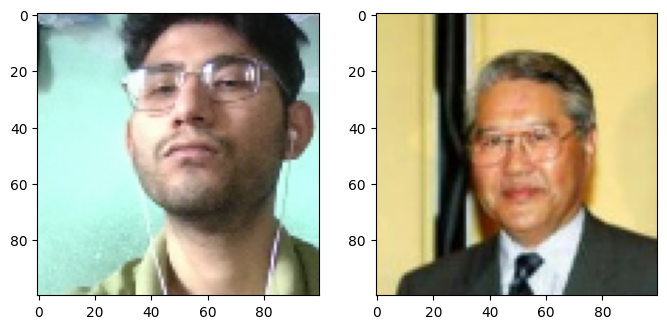

In [115]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(test_input[3])
plt.subplot(1,2,2)
plt.imshow(test_val[3])
plt.show()


In [116]:
#save the model
siamese_model.save("siamesemodel.h5")

In [117]:
L1Dist

__main__.L1Dist

In [118]:
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={"L1Dist":L1Dist, "BinaryCrossentropy":tf.losses.BinaryCrossentropy})

In [119]:
model.predict([test_input,test_val])

1/1 [==============================] - 0s 199ms/step


array([[3.6865423e-08],
       [9.9999833e-01],
       [9.9774361e-01],
       [4.0514789e-07],
       [3.8696632e-07],
       [4.3453876e-04],
       [1.0344560e-03],
       [6.2872818e-09],
       [2.1290914e-03],
       [9.9999845e-01],
       [9.9999976e-01],
       [4.5397091e-08],
       [2.7519691e-06],
       [1.8439582e-06],
       [5.3379544e-08],
       [2.2113379e-06]], dtype=float32)

In [120]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [124]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [125]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    
    #cut down frame to 250*250 px
    frame = frame[140:140+250,120:120+250,:]
    
    cv2.imshow('Verification', frame)
    
    #verification trigger
    # application_data\input_image
    if cv2.waitKey(10) & 0xFF == ord('v'):
        #save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('application_data','input_image','input_image.jpg'), frame)
        #run verification
        results , verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()
    

1/1 [==============================] - 0s 28ms/step
True
1/1 [==============================] - 0s 33ms/step
True


In [126]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [127]:
np.sum(np.squeeze(results) > 0.5)

52

In [31]:
14/50


0.28

In [36]:
np.sum(np.squeeze(results)>0.4)

14